# An initial look at the Harry Potter theme

## Introduction

**This notebook forms the first part of what will be a series of blog posts. It's currently a WIP.**

Harry Potter was always my favourite Lego theme, and now that it's back (to witches and wizards and magical beasts!) I've grabbed the database of lego sets and parts from [Rebrickable](https://rebrickable.com/downloads/) and had a look at some ways in which the theme has changed over the years. It also gave me a chance to do some visualisation with [Altair](https://altair-viz.github.io/), which is an awesome library for quick and interactive plots.

## Libraries and setup

In [1]:
import sqlite3
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

In [2]:
DB_PATH = Path("../../data/db")

In [3]:
!ls {DB_PATH}

20190511115712.log  lego.db


In [4]:
conn = sqlite3.connect(str(DB_PATH / "lego.db"))

In [5]:
def display_df(df:pd.DataFrame, n:int=5, df_shape:bool=False):
    """
    Shows the head, tail and shape (optional) of a pandas df
    """
    display(df.head(n), df.tail(n))
    if df_shape: print(f"rows: {df.shape[0]}, cols: {df.shape[1]}")

## Datasets

The data was downloaded from [Rebrickable](https://rebrickable.com/downloads/) and accurate as of 2019-05-08. I wrote a Python script to create a SQLite version of the original Rebrickable database using the provided scheme - you can download it [here](), along with the Jupyter Notebooks with the source code for most of this post (once I get around to committing them...).

I made a few minor changes to the data:
- I dropped four sets ([K4706-1](https://rebrickable.com/sets/K4706-1/sorcerers-stone-kit/), [K4701-1](https://rebrickable.com/sets/K4701-1/chamber-of-secrets-kit/), [K4729-1](https://rebrickable.com/sets/K4729-1/deluxe-hogwarts-kit/) and [5000068-1](https://rebrickable.com/sets/5000068-1/harry-potter-classic-kit/)). These are collections of other sets which were released separately and shouldn't be considered sets in their own right.
- I renamed the *Sorcerer's Stone* subtheme to *Philosopher's Stone*.
- Some sets have duplicate names e.g. Hogwarts, Hogwarts Express. These were renamed.

In [6]:
theme_order = ["Philosopher's Stone", "Chamber of Secrets", "Prisoner of Azkaban", "Goblet of Fire",
              "Order of the Phoenix", "Harry Potter", "Fantastic Beasts"]

### Related to subthemes and sets

In [7]:
cols = "sets.name, sets.set_num, sets.year, sets.num_parts, themes.name as theme_name"

hp_themes_df = pd.read_sql_query(
    f"""SELECT {cols} FROM sets
    JOIN themes on sets.theme_id = themes.id
    WHERE themes.name = 'Harry Potter'
        OR themes.name LIKE '%Sorcerer''s Stone%'
        OR themes.name = 'Chamber of Secrets'
        OR themes.name = 'Prisoner of Azkaban'
        OR themes.name = 'Goblet of Fire'
        OR themes.name = 'Order of the Phoenix'
        OR themes.name = 'Fantastic Beasts'""",
    conn)

In [8]:
hp_themes_df = hp_themes_df[hp_themes_df['year']!=2019].reset_index()

In [9]:
display_df(hp_themes_df, df_shape=True)

,index,name,set_num,year,num_parts,theme_name
0,0,Diagon Alley,10217-1,2011,2031,Harry Potter
1,1,Trolley,30110-1,2011,22,Harry Potter
2,2,The Lab,30111-1,2011,34,Harry Potter
3,3,Mini Hogwarts Express,40028-1,2011,64,Harry Potter
4,4,Freeing Dobby,4736-1,2010,73,Harry Potter


,index,name,set_num,year,num_parts,theme_name
76,81,Hogwarts Whomping Willow,75953-1,2018,756,Fantastic Beasts
77,82,Hogwarts Great Hall,75954-1,2018,882,Fantastic Beasts
78,83,Hogwarts Express,75955-1,2018,805,Fantastic Beasts
79,84,Quidditch Match,75956-1,2018,501,Fantastic Beasts
80,86,Golden Snitch,HP-SNITCH,2018,35,Fantastic Beasts


rows: 81, cols: 6


### Related to parts and colours

In [10]:
cols = """sets.set_num, sets.name, sets.year, sets.num_parts, color_id,
        parts.part_num, inventory_parts.quantity, colors.rgb, colors.is_trans, colors.name as color_name,
        themes.name as theme_name, inventories.id as inv_id, parts.name as part_name"""

hp_parts_df = pd.read_sql_query(
    f"""SELECT {cols} FROM sets
    JOIN themes on sets.theme_id = themes.id
    JOIN inventories on sets.set_num = inventories.set_num
    JOIN inventory_parts on inventories.id = inventory_parts.inventory_id
    JOIN parts on inventory_parts.part_num = parts.part_num
    JOIN colors on inventory_parts.color_id = colors.id
    WHERE themes.name = 'Harry Potter'
        OR themes.name LIKE '%Sorcerer''s Stone%'
        OR themes.name = 'Chamber of Secrets'
        OR themes.name = 'Prisoner of Azkaban'
        OR themes.name = 'Goblet of Fire'
        OR themes.name = 'Order of the Phoenix'
        OR themes.name = 'Fantastic Beasts'
        AND sets.year != 2019""",
    conn)

In [11]:
display_df(hp_parts_df, df_shape=True)

,set_num,name,year,num_parts,color_id,part_num,quantity,rgb,is_trans,color_name,theme_name,inv_id,part_name
0,10132-1,Motorized Hogwarts Express,2004,712,72,2039,2,6C6E68,f,Dark Bluish Gray,Prisoner of Azkaban,10570,Lamp Post 2 x 2 x 7 with 6 Base Flutes
1,10132-1,Motorized Hogwarts Express,2004,712,4,2357,2,C91A09,f,Red,Prisoner of Azkaban,10570,Brick 2 x 2 Corner
2,10132-1,Motorized Hogwarts Express,2004,712,72,2357,21,6C6E68,f,Dark Bluish Gray,Prisoner of Azkaban,10570,Brick 2 x 2 Corner
3,10132-1,Motorized Hogwarts Express,2004,712,4,2377,2,C91A09,f,Red,Prisoner of Azkaban,10570,Window 1 x 2 x 2 Plane
4,10132-1,Motorized Hogwarts Express,2004,712,72,2412b,11,6C6E68,f,Dark Bluish Gray,Prisoner of Azkaban,10570,Tile Special 1 x 2 Grille with Bottom Groove


,set_num,name,year,num_parts,color_id,part_num,quantity,rgb,is_trans,color_name,theme_name,inv_id,part_name
9051,TRUWEASLEYCAR-1,Weasley Family Car,2018,36,36,6141,2,C91A09,t,Trans-Red,Harry Potter,29494,Plate Round 1 x 1 with Solid Stud
9052,TRUWEASLEYCAR-1,Weasley Family Car,2018,36,15,87079,1,FFFFFF,f,White,Harry Potter,29494,Tile 2 x 4 with Groove
9053,TRUWEASLEYCAR-1,Weasley Family Car,2018,36,73,87087,2,5A93DB,f,Medium Blue,Harry Potter,29494,Brick Special 1 x 1 with Stud on 1 Side
9054,TRUWEASLEYCAR-1,Weasley Family Car,2018,36,71,93590,2,A0A5A9,f,Light Bluish Gray,Harry Potter,29494,"Vehicle, Mudguard 2 x 4 with Headlights and Cu..."
9055,TRUWEASLEYCAR-1,Weasley Family Car,2018,36,47,98138,2,FCFCFC,t,Trans-Clear,Harry Potter,29494,Tile Round 1 x 1


rows: 9056, cols: 13


## Global data cleaning and new features

I've dropped sets [K4706-1](https://rebrickable.com/sets/K4706-1/sorcerers-stone-kit/), [K4701-1](https://rebrickable.com/sets/K4701-1/chamber-of-secrets-kit/), [K4729-1](https://rebrickable.com/sets/K4729-1/deluxe-hogwarts-kit/) and [5000068-1](https://rebrickable.com/sets/5000068-1/harry-potter-classic-kit/) as they are technically collections of other sets, as opposed to being sets in their own right.

In [12]:
dfs = [hp_themes_df, hp_parts_df]

for df in dfs:
    # Drop collections
    df.drop(df[df['set_num'].isin(['K4706-1', 'K4701-1', 'K4729-1', '5000068-1'])]\
            .index, axis=0, inplace=True)
    
    # Fixes identically named sets
    # Changes 'Sorcerer's Stone' to 'Philosopher's Stone'
    df.loc[df['theme_name']=="Sorcerer's Stone", 'theme_name'] = "Philosopher's Stone"
    df.loc[(df['name']=='Hogwarts Castle') & (df['theme_name']=='Order of the Phoenix'), 'name'] = 'Hogwarts (Third Edition)'
    df.loc[(df['name']=='Hogwarts Castle') & (df['theme_name']=="Sorcerer's Stone"), 'name'] = 'Hogwarts (First Edition)'
    df.loc[(df['name']=='Diagon Alley') & (df['theme_name']=='Harry Potter'), 'name'] = 'Diagon Alley'
    df.loc[(df['name']=='Diagon Alley') & (df['theme_name']=='Fantastic Beasts'), 'name'] = 'Diagon Alley (micro)'
    df.loc[(df['name']=='Hogwarts Express') & (df['theme_name']=="Philosopher's Stone"), 'name'] = 'Hogwarts Express (1st Edition)'
    df.loc[(df['name']=='Hogwarts Express') & (df['theme_name']=='Fantastic Beasts'), 'name'] = 'Hogwarts Express (4th Edition)'
    
    # Combines set_num and name columns
    # Set number is uniquely identifying but opaque
    df['num_name'] = df['set_num'] + ": " + df["name"]

### Year

In [13]:
# Compute count of sets by year
hp_yearsets_df = hp_themes_df[['year', 'theme_name', 'name']]\
    .groupby(['theme_name', 'year'], as_index=False)['name']\
    .count()\
    .rename(columns={'name': 'year_count'})

# Compute count of sets by theme
hp_themesets_df = hp_themes_df[['theme_name', 'name']]\
    .groupby(['theme_name'], as_index=False)['name']\
    .count()\
    .rename(columns={'name': 'set_count'})

# Combine datasets
hp_yearsets_df = hp_yearsets_df.merge(hp_themesets_df, on="theme_name", how="left")

hp_yearsets_df.head(10)

,theme_name,year,year_count,set_count
0,Chamber of Secrets,2002,8,10
1,Chamber of Secrets,2003,2,10
2,Fantastic Beasts,2018,12,12
3,Goblet of Fire,2005,5,5
4,Harry Potter,2002,6,21
5,Harry Potter,2010,6,21
6,Harry Potter,2011,7,21
7,Harry Potter,2018,2,21
8,Order of the Phoenix,2007,1,1
9,Philosopher's Stone,2001,11,14


### Parts

In [14]:
# Get name of set with most parts per theme
most_parts = hp_themes_df\
    .groupby('theme_name')['num_name', 'num_parts']\
    .apply(lambda grp: grp.nlargest(1, 'num_parts'))\
    .reset_index()[['theme_name', 'num_name']]\
    .rename(columns={'num_name': 'most_parts'})

hp_themes_df = hp_themes_df.merge(most_parts, on="theme_name", how="right")

### Colours

For each part in a set, the db gives information about its colour and quantity e.g.:

In [15]:
hp_parts_df[['name', 'color_name', 'part_name', 'quantity']].head(1)

,name,color_name,part_name,quantity
0,Motorized Hogwarts Express,Dark Bluish Gray,Lamp Post 2 x 2 x 7 with 6 Base Flutes,2


For investigating changes in the colour palette, this was expanded so each row represented a discrete color-part pair:

In [16]:
hp_colors_df = hp_parts_df\
    .reindex(hp_parts_df.index.repeat(hp_parts_df['quantity']))

# For plots, the rgb value needs to be a valid hex color code with # prefix
hp_colors_df['hex'] = '#' + hp_colors_df['rgb']

# Example expanded colour df
hp_colors_df[['name', 'color_name', 'part_name']].head(2)

,name,color_name,part_name
0,Motorized Hogwarts Express,Dark Bluish Gray,Lamp Post 2 x 2 x 7 with 6 Base Flutes
0,Motorized Hogwarts Express,Dark Bluish Gray,Lamp Post 2 x 2 x 7 with 6 Base Flutes


In [17]:
# Create different groupings of colour counts:

# By year
colors_count_year = hp_colors_df.groupby(['year', 'color_name', 'hex'], as_index=False)\
    .count()[['year', 'hex', 'quantity', 'color_name']]
colors_count_year['transparent'] = colors_count_year['hex'].isin(list(hp_colors_df[hp_colors_df['is_trans'] == 't']['hex']))

# By theme
colors_count_theme = hp_colors_df.groupby(['theme_name', 'color_name', 'hex'], as_index=False)\
    .count()[['theme_name', 'hex', 'quantity', 'color_name']]
colors_count_theme['transparent'] = colors_count_theme['hex'].isin(list(hp_colors_df[hp_colors_df['is_trans'] == 't']['hex']))

# By set
colors_count_set = hp_colors_df.groupby(['theme_name', 'num_name', 'name', 'color_name', 'hex'], as_index=False)\
    .count()[['theme_name', 'num_name', 'name', 'hex', 'quantity', 'color_name', 'num_parts']]
colors_count_set['transparent'] = colors_count_set['hex'].isin(list(hp_colors_df[hp_colors_df['is_trans'] == 't']['hex']))

In [18]:
# Size of the palette
# By year
colors_number_year = hp_parts_df.groupby(['year'])['color_name']\
    .nunique()\
    .reset_index(name='color_count')\
    .rename(columns={'color_name': 'color_count'})

# By theme
colors_number_theme = hp_parts_df.groupby(['theme_name'])['color_name']\
    .nunique()\
    .reset_index(name='color_count')\
    .rename(columns={'color_name': 'color_count'})

# By set
colors_number_set = hp_parts_df.groupby(['set_num'])['color_name']\
    .nunique()\
    .reset_index(name='color_count')\
    .rename(columns={'color_name': 'color_count'})

## Sets released by year

The launch of the theme coincided with the beginning of the film franchise in 2001. While initially popular, with many sets released, demand waned somewhat. Combined with serious financial problems at Lego, this saw the number of sets released each year sharply declining and culminated in the theme being discontinued in 2007. At this point, the last three films (Half-blood Prince and Deathly Hallows Parts 1 and 2) had not yet been released.

This discontinuation was somewhat temporary, but while the theme briefly returned, only three sets ([4840-1: The Burrow](https://brickset.com/sets/4840-1/The-Burrow), along with [4867-1: Hogwarts](https://rebrickable.com/sets/4867-1/hogwarts/) and [4865-1: The Forbidden Forest](https://rebrickable.com/sets/4865-1/the-forbidden-forest/)) explicitly referenced events in the last three films. As can be seen in the plot below, the theme was discontinued for a second time in 2011.

The release of the Fantastic Beasts franchise (and, likely, growing demand for Harry Potter merchandise in general) gave Lego an opportunity to revive the theme yet again, starting to release new sets in 2018. While the Rebrickable database categorises all these sets under the *Fantastic Beasts* theme, only three sets to date are based on these films. The majority are based on the events in *Philosopher's Stone* and *Chamber of Azkaban*, with some scenes from *Prisoner of Azkaban* represented in [75955-1: Hogwarts Express](https://brickset.com/sets/75955-1/Hogwarts-Express). 2019 is bringing more, continuing *Prisoner of Azkaban* and introducing sets from *Goblet of Fire*. None announced so far relate to the Fantastic Beasts franchise...

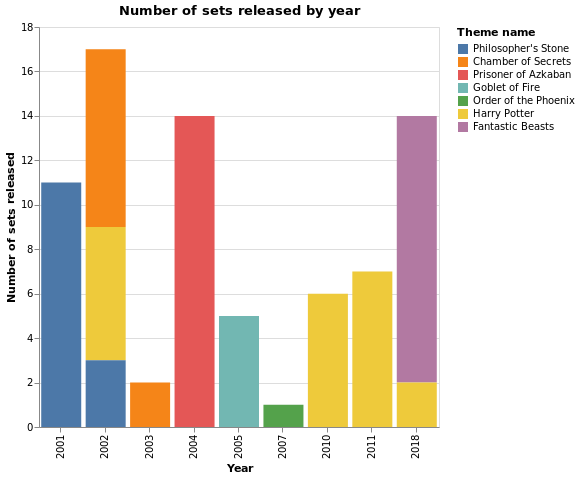

In [19]:
# Plot of sets released by year
# Hover over for tooltip of total sets in a given theme
plot_sets_year = alt.Chart(hp_yearsets_df).mark_bar().encode(
    x=alt.X('year:O', title='Year'),
    y=alt.Y('year_count:Q', title='Number of sets released'),
    color=alt.Color('theme_name:N', title='Theme name', sort=theme_order),
    tooltip=alt.Tooltip(['set_count:Q'], title='Total sets in theme')
).properties(
    width=400,
    height=400,
    title='Number of sets released by year'
)

plot_sets_year.save('hp_plt_sets_year.html')

plot_sets_year

In [20]:
hp_themes_df[(hp_themes_df['theme_name']=='Harry Potter') & (hp_themes_df['year']==2011)]

,index,name,set_num,year,num_parts,theme_name,num_name,most_parts
0,0,Diagon Alley,10217-1,2011,2031,Harry Potter,10217-1: Diagon Alley,10217-1: Diagon Alley
1,1,Trolley,30110-1,2011,22,Harry Potter,30110-1: Trolley,10217-1: Diagon Alley
2,2,The Lab,30111-1,2011,34,Harry Potter,30111-1: The Lab,10217-1: Diagon Alley
3,3,Mini Hogwarts Express,40028-1,2011,64,Harry Potter,40028-1: Mini Hogwarts Express,10217-1: Diagon Alley
10,10,The Forbidden Forest,4865-1,2011,64,Harry Potter,4865-1: The Forbidden Forest,10217-1: Diagon Alley
11,11,The Knight Bus,4866-1,2011,281,Harry Potter,4866-1: The Knight Bus,10217-1: Diagon Alley
12,12,Hogwarts,4867-1,2011,465,Harry Potter,4867-1: Hogwarts,10217-1: Diagon Alley


## Number of parts

### Number of parts

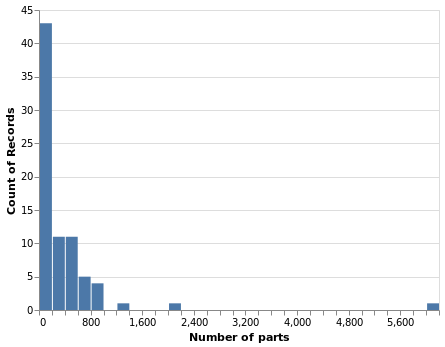

In [21]:
alt.Chart(hp_themes_df).mark_bar().encode(
    x=alt.X('num_parts:Q', title='Number of parts', bin=alt.Bin(maxbins=50)),
    y=alt.Y('count()')
    )

### Number of parts by year and theme

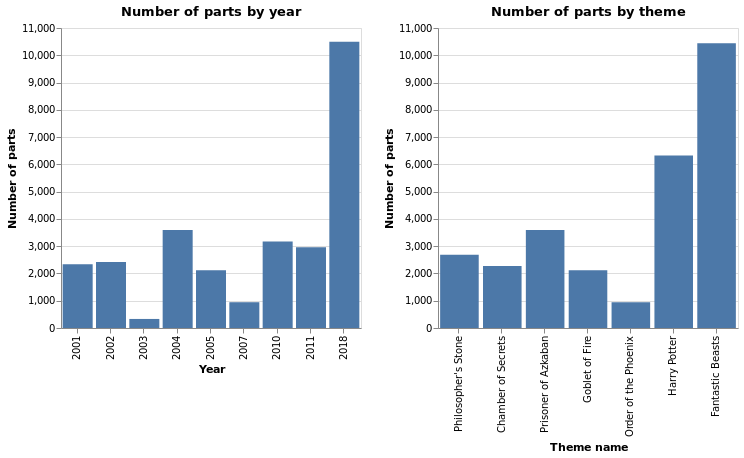

In [22]:
plot_parts_year = alt.Chart(hp_themes_df).mark_bar().encode(
    x=alt.X('year:O', title='Year'),
    y=alt.Y('sum(num_parts):Q', title='Number of parts')
).properties(
    height=300,
    width=300,
    title='Number of parts by year'
)

plot_parts_theme = alt.Chart(hp_themes_df).mark_bar().encode(
    x=alt.X('theme_name:O', title='Theme name', sort=theme_order),
    y=alt.Y('sum(num_parts):Q', title='Number of parts'),
    tooltip=alt.Tooltip(["most_parts:N"], title="Set with most parts")
).properties(
    height=300,
    width=300,
    title='Number of parts by theme'
)

plot_parts_year | plot_parts_theme

The *Fantastic Beasts* theme part count is skewed almost entirely by the very large 6020 part [71043-1: Hogwarts Castle](https://rebrickable.com/sets/71043-1/hogwarts-castle) set (listed here as 6016 parts for...some reason). Log-transforming the feature provides an alternative comparison:

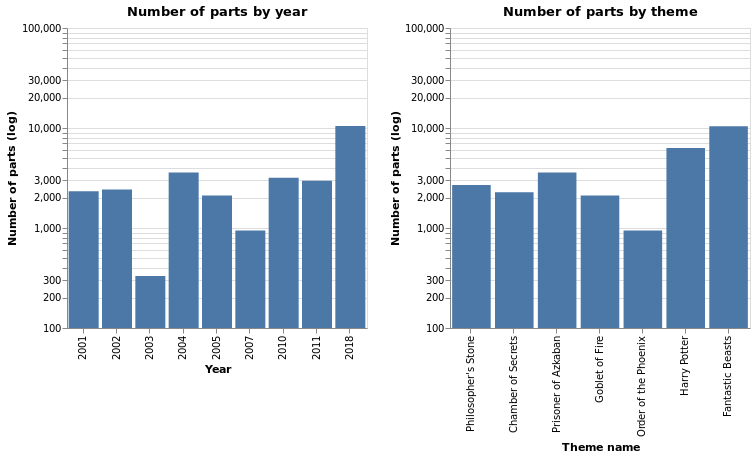

In [23]:
plot_parts_year = alt.Chart(hp_themes_df).mark_bar().encode(
    x=alt.X('year:O', title='Year'),
    y=alt.Y('sum(num_parts):Q', scale=alt.Scale(type='log'), title='Number of parts (log)')
).properties(
    height=300,
    width=300,
    title='Number of parts by year'
)

plot_parts_theme = alt.Chart(hp_themes_df).mark_bar().encode(
    x=alt.X('theme_name:O', title='Theme name', sort=theme_order),
    y=alt.Y('sum(num_parts):Q', scale=alt.Scale(type='log'), title='Number of parts (log)'),
    tooltip=alt.Tooltip(["most_parts:N"], title="Set with most parts")
).properties(
    height=300,
    width=300,
    title='Number of parts by theme'
)

plot_parts_year | plot_parts_theme

The below table shows the five sets with the highest part counts for each theme:

In [24]:
hp_themes_df.groupby('theme_name')['name', 'num_parts'].apply(lambda grp: grp.nlargest(5, 'num_parts')).reset_index(0)

,theme_name,name,num_parts
27,Chamber of Secrets,Chamber of Secrets,597
26,Chamber of Secrets,Dumbledore's Office,451
25,Chamber of Secrets,Escape from Privet Drive,282
22,Chamber of Secrets,Knockturn Alley,211
24,Chamber of Secrets,Aragog in the Dark Forest,183
67,Fantastic Beasts,Hogwarts Castle,6016
73,Fantastic Beasts,Hogwarts Great Hall,882
74,Fantastic Beasts,Hogwarts Express (4th Edition),805
72,Fantastic Beasts,Hogwarts Whomping Willow,756
71,Fantastic Beasts,Newt's Case of Magical Creatures,694


## Colours

### Size of the colour palette

The plots below show the total number of different colours of parts in sets released by both year and subtheme.

In [25]:
colors_number_year = colors_number_year.merge(
    hp_themes_df.groupby(['year'])['num_parts'].sum().reset_index()
)

colors_number_set = colors_number_set.merge(
    hp_themes_df[['set_num', 'num_parts', 'num_name']]
)
# The num_parts feature is heavily right-skewed.
# Log-transforming the feature normalises it
colors_number_set['log_num_parts'] = np.log(colors_number_set['num_parts'])

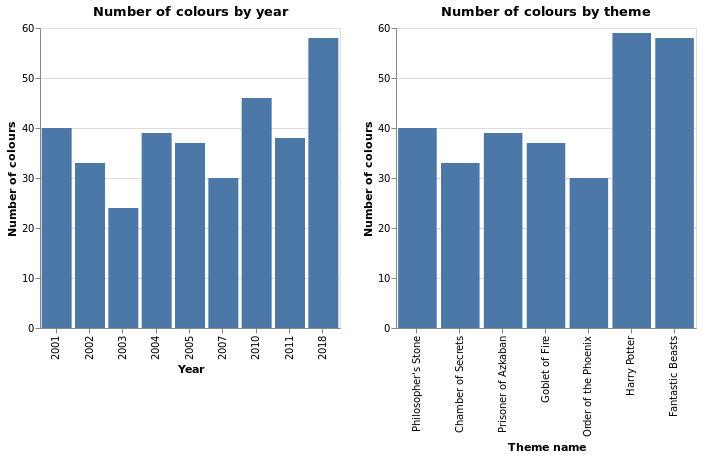

In [26]:
year_colors = alt.Chart(colors_number_year).mark_bar().encode(
    x=alt.X('year:N', title='Year'),
    y=alt.Y('color_count:Q', title='Number of colours')
).properties(
    height=300,
    width=300,
    title='Number of colours by year'
)

theme_colors = alt.Chart(colors_number_theme).mark_bar().encode(
    x=alt.X('theme_name:N', sort=theme_order, title='Theme name'),
    y=alt.Y('color_count:Q', title='Number of colours')
).properties(
    height=300,
    width=300,
    title='Number of colours by theme'
)

year_colors | theme_colors

Sets in both the *Harry Potter* and the *Fantastic Beasts* themes have more colours in their palettes than those in other themes. However, recall that the two largest Harry Potter sets ([10217-1: Diagon Alley](https://rebrickable.com/sets/10217-1/diagon-alley/) and [71043-1: Hogwarts Castle](https://rebrickable.com/sets/71043-1/hogwarts-castle)) are in these themes. The plot below shows the correlation ($r$ = 0.845) between the number of parts and the size of the colour palette for each set.

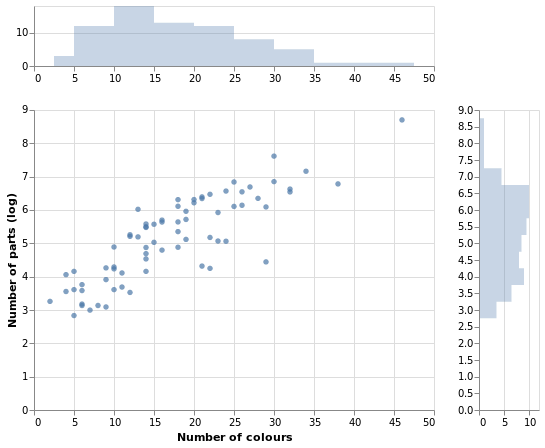

In [27]:
xscale = alt.Scale(domain=(0,50))
yscale = alt.Scale(domain=(0, 9))
area_args = {'opacity': .3, 'interpolate': 'step'}

scatter_color = alt.Chart(colors_number_set).mark_circle().encode(
    x=alt.X('color_count:Q', scale=xscale, title='Number of colours'),
    y=alt.Y('log_num_parts:Q', scale=yscale, title='Number of parts (log)'),
    tooltip='num_name:N'
)
top_hist = alt.Chart(colors_number_set).mark_area(**area_args).encode(
    x=alt.X('color_count:Q', bin=alt.Bin(maxbins=20, extent=xscale.domain), title=''),
    y=alt.Y('count()', title='')
).properties(height=60)

right_hist = alt.Chart(colors_number_set).mark_area(**area_args).encode(
    y=alt.Y('log_num_parts:Q', bin=alt.Bin(maxbins=20, extent=yscale.domain), title=''),
    x=alt.X('count()', title='')
).properties(width=60)

top_hist & (scatter_color | right_hist)

In [28]:
colors_number_set[['color_count', 'log_num_parts']].corr(method='pearson')

,color_count,log_num_parts
color_count,1.000000,0.845327
log_num_parts,0.845327,1.000000


### Colour by year

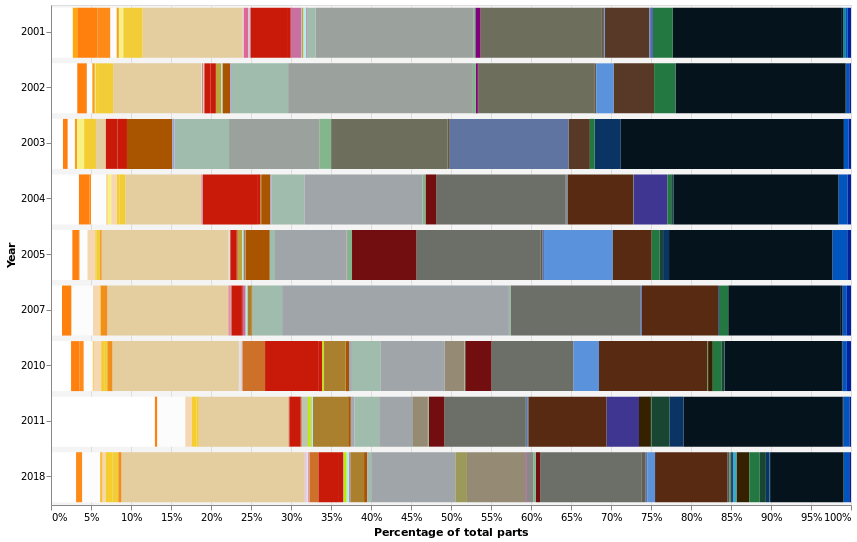

In [29]:
click = alt.selection_multi(encodings=['color'])

alt.Chart(colors_count_year).mark_bar().encode(
    x=alt.X('sum(quantity)', stack="normalize", axis=alt.Axis(format='%', title='Percentage of total parts')),
    y=alt.Y("year:O", title='Year'),
    color=alt.condition(click, alt.Color("hex:N", scale=None), alt.value('lightgray')),
    tooltip=(['color_name', 'quantity', 'transparent:N'])
).properties(
    height=500,
    width=800
).add_selection(click).interactive().configure_view(
    fill='#f4f4f4'
)

### Colour by theme

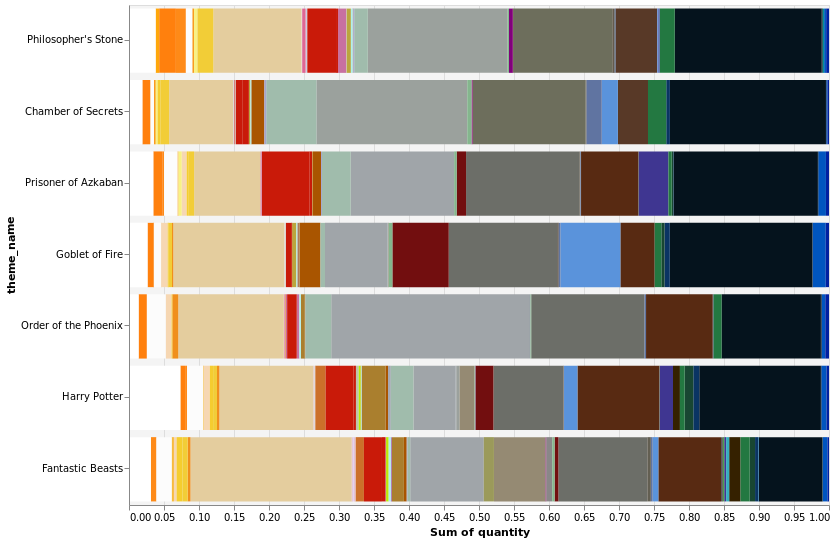

In [30]:
click = alt.selection_multi(encodings=['color'])

alt.Chart(colors_count_theme).mark_bar().encode(
    x=alt.X('sum(quantity)', stack="normalize"),
    y=alt.Y("theme_name:O", sort=theme_order),
    color=alt.condition(click, alt.Color("hex:N", scale=None), alt.value('lightgray')),
    tooltip=(['color_name', 'quantity', 'transparent:N'])
).properties(
    height=500,
    width=700
).add_selection(click).interactive().configure_view(
    fill='#f4f4f4'
)

For both themes and years the colour palette is dominated by grays (Lego changed from Light and Dark Gray to Light and Dark Bluish Gray), Tan, Black and Brown. Sand Green was widely used for the roofs of Hogwarts-related sets, but the relaunch of the theme in 2018 saw this almost universally replaced with Dark Bluish Gray, with the original colour only retained for rooftop finials.

### Colour by set

The plot below shows the colour breakdown of each set. While the pattern observed above (large numbers of Tan, Gray, Black and Brown parts) holds for the majority of sets, some deviate considerably from that - notable examples being the Knight Bus sets which are almost entirely constructed from purple bricks.

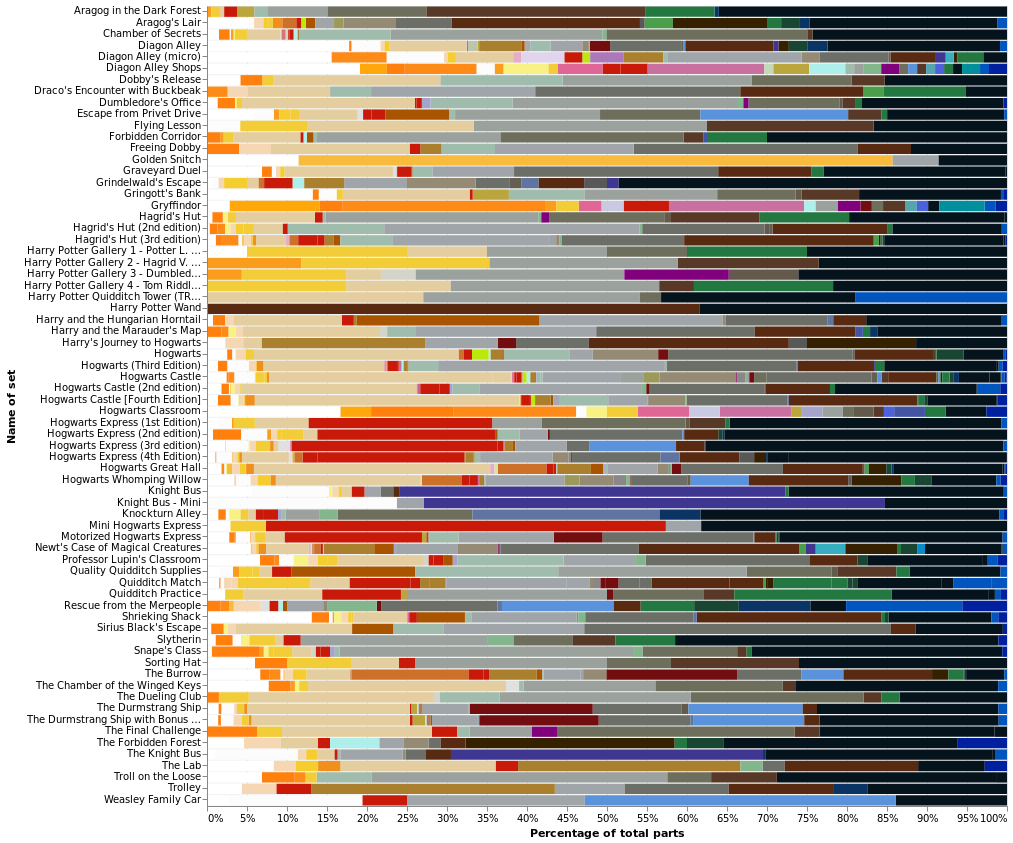

In [31]:
click = alt.selection_multi(encodings=['color'])

alt.Chart(colors_count_set).mark_bar().encode(
    x=alt.X('sum(quantity)', stack="normalize", axis=alt.Axis(format='%', title='Percentage of total parts')),
    y=alt.Y("name:O", title='Name of set'),
    color=alt.condition(click, alt.Color("hex:N", scale=None), alt.value('lightgray')),
    tooltip=[
        alt.Tooltip('num_name:N', title='Set name'),
        alt.Tooltip('theme_name:N', title='Theme'),
        alt.Tooltip('color_name:N', title='Color'),
        alt.Tooltip('quantity:Q', title='Quantity'),
        alt.Tooltip('transparent:N', title='Transparent')
    ]
).properties(
    height=800,
    width=800
).add_selection(click).interactive().configure_view(
    fill='#f4f4f4'
)

### Zipf's Law

As a bit of a digression, the distribution of the colour of parts in Harry Potter Lego roughly follows [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law). This is widely observed, especially with text data. To use an example from that field, the law states that, for any corpus, the second-most frequent word will occur half as often as the most frequent, the third-most frequent half as often as the second and so on. In other words, the frequency of an item is inversely proportional to its rank in a frequency table.

In [32]:
color_count = hp_colors_df.groupby('hex')['hex']\
    .count()\
    .to_frame()\
    .rename(columns={'hex': 'count'})\
    .sort_values('count', ascending=False)\
    .reset_index()
color_count['rank'] = color_count.index + 1
color_count['log_freq'] = np.log(color_count['count'])
color_count['log_rank'] = np.log(color_count['rank'])

In [33]:
linear = pd.DataFrame({'xfit': np.linspace(color_count['log_rank'].min(), color_count['log_rank'].max(), 500)})
linear['yfit'] = np.poly1d(np.polyfit(color_count['log_rank'], color_count['log_freq'], 1))(linear['xfit'])

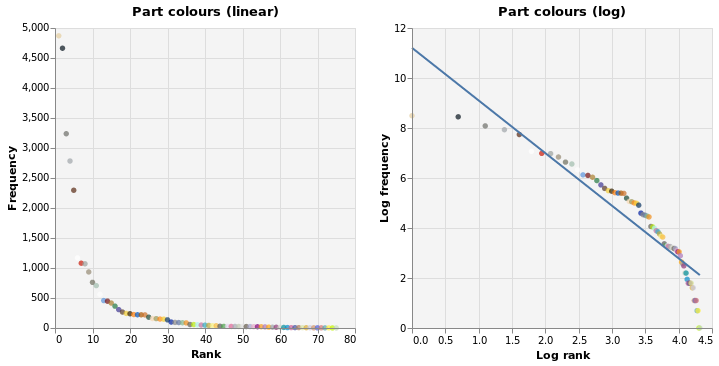

In [34]:
lin_lin = alt.Chart(color_count).mark_circle().encode(
    x=alt.X('rank:Q', title='Rank'),
    y=alt.Y('count:Q', title='Frequency'),
    color=alt.Color("hex:N", scale=None),
    tooltip=['hex:N']
).properties(
    height=300,
    width=300,
    title='Part colours (linear)'
)

log_log = alt.Chart(color_count).mark_circle().encode(
    x=alt.X('log_rank:Q', title='Log rank'),
    y=alt.Y('log_freq:Q', title='Log frequency'),
    color=alt.Color("hex:N", scale=None),
    tooltip=['hex:N']
).properties(
    height=300,
    width=300,
    title='Part colours (log)'
)

fit_line = alt.Chart(linear).mark_line().encode(
    x=alt.X('xfit:Q', title='Log rank'),
    y=alt.Y('yfit:Q', title='Log frequency')
).properties(
    height=300,
    width=300
)

chart = alt.hconcat(lin_lin, log_log + fit_line).configure_view(
    fill='#f4f4f4'
)

chart

In [35]:
# color_count['ideal'] = 1 / color_count['rank']
# color_count['zipf'] = color_count['count'] * color_count['ideal']
# color_count